##### Visualize Mixing Depth and PAR over full hindcast <br>
G Oldford
May 2023

Purpose: generate indices of productivity for phyto groups using P-I curves
         and functional response to mixing or stratification
         
Data in: PAR, mixing as ASC (monthly, clipped to ECOSPACE - NC's after initial invest)
         - P-I curve params


Notes: 


To-do: 
- May 14 2023 - the PAR attr keeps it's original name even after enviro function is applied - fix this


In [426]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} statsmodels

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Greig\anaconda3

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boltons-23.0.0             |   py39haa95532_0         421 KB
    conda-23.3.1               |   py39haa95532_0         972 KB
    jsonpatch-1.32             |     pyhd3eb1b0_0          15 KB
    jsonpointer-2.1            |     pyhd3eb1b0_0           9 KB
    ------------------------------------------------------------
                                           Total:         1.4 MB

The following NEW packages will be INSTALLED:

  boltons            pkgs/main/win-64::boltons-23.0.0-py39haa95532_0 
  jsonpatch          pkgs/main/noarch::jsonpatch-1.32-pyhd3eb1b0_0 
  jsonpointer        pkgs/main/noarch::jsonpointer-2.1-pyhd3eb1b0_0 
  scipy         


The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==2022.10=py39_0
  - defaults/win-64::datashader==0.14.1=py39haa95532_0
  - defaults/win-64::gensim==4.1.2=py39hd77b12b_0
  - defaults/win-64::scikit-image==0.19.2=py39hf11a4ad_0
  - defaults/win-64::scikit-learn==1.0.2=py39hf11a4ad_1
  - defaults/win-64::scikit-learn-intelex==2021.6.0=py39haa95532_0
  - defaults/noarch::seaborn==0.11.2=pyhd3eb1b0_0
  - defaults/win-64::statsmodels==0.13.2=py39h2bbff1b_0


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import math

import cartopy as cp
import matplotlib.pyplot as plt
import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

In [4]:
## Load data as-is into xarray dataset and then row-wise avg as xr

path_data = "../data/output/RUN203/ECOSPACE/"
mxng_p = "NEMO_prepped_as_ASC/{var}/"
tmp_p = "NEMO_prepped_as_ASC/{var}/"
li_p = "ECOSPACE_in_PAR3_Sal10m/{var}/"
k_p = "ECOSPACE_in_PAR3_Sal10m/RUN203_{var}/"
sal_p = "NEMO_prepped_as_ASC/{var}/"

path_data2 = "../data/forcing/"
li_p2 = "RDRS_light_monthly_ASC/{var}/"
wi_p = "RDRS_wind_monthly_ASC/{var}/"

# template file names w/ var names
v_f = {"MixedLyrZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc", 
       "MixingTurboZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "TempVertMean":path_data + tmp_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "TempVertMean10m":path_data + tmp_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",  
       "PAR-VarZ-VarK":path_data + li_p + "{var}_{year}_{month}.asc",  
       "Kfromsal":path_data + k_p + "RUN203_{var}_{year}_{month}.asc",
       "SalinVertMean":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "SalinVertMean10m":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "zvelocMean10m":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "solar_rad":path_data2 + li_p2 + "RDRS21_NEMOgrid_{var}_{year}_{month}.asc",
       "u10m":path_data2 + wi_p + "RDRS21_NEMOgrid_{var}_{year}_{month}.asc",
       "v10m":path_data2 + wi_p + "RDRS21_NEMOgrid_{var}_{year}_{month}.asc"
      }

yr_strt = 1980
yr_end = 2017
months_d = {"01": 1, "02": 2, "03": 3,"04": 4,"05": 5,"06": 6,"07": 7,"08": 8,"09": 9,"10": 10,"11": 11,"12": 12}
months = list(range(1,12))

rows = 151
cols = 93
months = 12

skiprows = 6 # header

time = pd.date_range(start='{yr_strt}-01-01'.format(yr_strt=yr_strt), 
                              end='{yr_end}-12-01'.format(yr_end=yr_end), 
                              freq='MS')+ pd.DateOffset(days=14)

# empty ds for all 
ds = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'Example dataset of monthly ASC files',
    }
)

# create empty variable with correct shape
for v in v_f:
    ds[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows, cols)),
        dims=('time', 'row', 'col'),
        attrs={'description': f'{v} data'}
    )

# load the data
for v in v_f:
    attribute = v_f[v]
    for y in range(yr_strt, yr_end+1):
        for m in sorted(months_d.keys()):
            f_n = v_f[v].format(var=v,year=y,month=m)
            with open(f_n) as f:
                data = np.loadtxt(f,skiprows=skiprows)
                
                # homogenize what nans are
                data[data==-9999.0]=['nan']
                data[data==0.0]=['nan']
                
                # fix issue with bottom left area in map
                data[140:,:15]=['nan']
                
                ds[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    data,
                    dims=('row', 'col'),
                    attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )
                          

### Calculate response to light for diatoms, dinoflagellates, flagellates, pico, nano, bac

In [6]:
# based on Sarmiento & Gruber, 2006 (p. 135; fig 4.2.9) which is based on Parsons et al., 1984 (p. 79) and 
# Parsons references 
dia_I_opt = 23
din_I_opt = 40
fla_I_opt = 40

# eqn for P-I curve based on Steele form see Merico et al., 2004, p. 1822, Appendix A, Eqn A.3
# I/I_opt * exp(1 - I/I_opt)
# note there is an excel sheet where I experimented with different curvatures


# empty ds for PI response 
ds_PI = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'PI response',
    }
)

# create empty variable with correct shape
for v in v_f:
    if v == "PAR-VarZ-VarK":
        ds_PI[v] = xr.DataArray(
            np.nan*np.zeros((len(time), rows, cols)),
            dims=('time', 'row', 'col'),
            attrs={'description': f'PI response values'}
        )

# load the data
for v in v_f:
    if v == "PAR-VarZ-VarK":
        attribute = v_f[v]
        for y in range(yr_strt, yr_end+1):
            for m in sorted(months_d.keys()):
                f_n = v_f[v].format(var=v,year=y,month=m) # open the monthly ASC
                
                with open(f_n) as f:
                    data = np.loadtxt(f,skiprows=skiprows)

                    # homogenize what nans are
                    data[data==-9999.0]=['nan']
                    data[data==0.0]=['nan']

                    # fix issue with bottom left area in map
                    data[140:,:15]=['nan']
                    
                    ds_PI[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                        data,
                        dims=('row', 'col'),
                        attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                    )

# see above for info                
dia_PI = ds_PI / dia_I_opt * math.exp(1) ** (1 - ds_PI/dia_I_opt) 
din_PI = ds_PI / din_I_opt * math.exp(1) ** (1 - ds_PI/din_I_opt) 
fla_PI = ds_PI / fla_I_opt * math.exp(1) ** (1 - ds_PI/fla_I_opt) 
#I/I_opt * exp(1 - I/I_opt)

### Parameterize the mixing / mixed depth functional response for PP

In [7]:
mix_var = "MixedLyrZ"
#mix_var = "MixingTurboZ"

# empty ds for MIXING response (0 - 1) 
ds_MI = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'Mixing response',
    }
)

# create empty variable with correct shape
for v in v_f:
    if v == mix_var:
        ds_MI[v] = xr.DataArray(
            np.nan*np.zeros((len(time), rows, cols)),
            dims=('time', 'row', 'col'),
            attrs={'description': f'Mixing response values'}
        )

# load the data
for v in v_f:
    if v == mix_var:
        attribute = v_f[v]
        for y in range(yr_strt, yr_end+1):
            for m in sorted(months_d.keys()):
                f_n = v_f[v].format(var=v,year=y,month=m) # open the monthly ASC
                
                with open(f_n) as f:
                    data = np.loadtxt(f,skiprows=skiprows)

                    # homogenize what nans are
                    data[data==-9999.0]=['nan']
                    data[data==0.0]=['nan']

                    # fix issue with bottom left area in map
                    data[140:,:15]=['nan']
                    
                    ds_MI[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                        data,
                        dims=('row', 'col'),
                        attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                    )

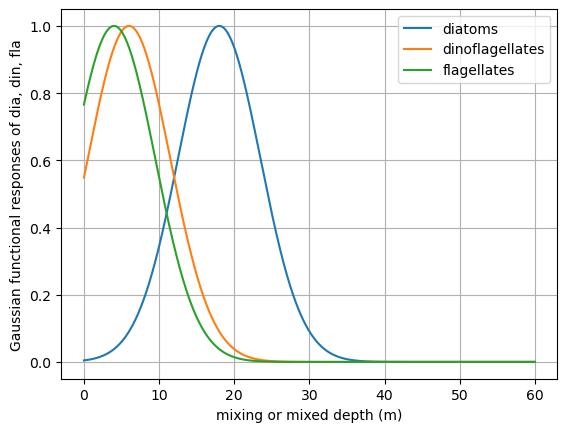

In [8]:
# these are guesses based on the climatology of mixed layer (or mixing layer) from previous notebook
# opt = mean for gaussian function
dia_M_opt = 18
din_M_opt = 6
fla_M_opt = 4

# var = variance for tuning gaussian
dia_M_var = 30
din_M_var = 30
fla_M_var = 30


# visual for tuning (function used is in next cell below)
x = np.linspace(0, 60,1200)

# apply gaussian function
dia_y = np.exp(-0.5 * ((x - dia_M_opt) ** 2) / dia_M_var) / np.sqrt(2 * np.pi * dia_M_var)
din_y = np.exp(-0.5 * ((x - din_M_opt) ** 2) / din_M_var) / np.sqrt(2 * np.pi * din_M_var)
fla_y = np.exp(-0.5 * ((x - fla_M_opt) ** 2) / fla_M_var) / np.sqrt(2 * np.pi * fla_M_var)

# rescale to 1.0
dia_y /= np.max(dia_y)
din_y /= np.max(din_y)
fla_y /= np.max(fla_y)

plt.plot(x, dia_y, label="diatoms")
plt.plot(x, din_y, label="dinoflagellates")
plt.plot(x, fla_y, label="flagellates")
plt.xlabel('mixing or mixed depth (m)')
plt.ylabel('Gaussian functional responses of dia, din, fla')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
def gaussian_fnc(ds_MI, M_opt, M_var, mix_var):
    MI = math.exp(1) ** (-0.5 * ((ds_MI - M_opt) ** 2) / M_var) / math.sqrt(2 * math.pi * M_var)
    
    # rescale out of 1.0
    reshaped_data = MI[mix_var].stack(points=('row', 'col'))
    flattened_data = reshaped_data.values.flatten()
    
    MI = MI / np.nanmax(flattened_data)
    return(MI)

dia_MI = gaussian_fnc(ds_MI, dia_M_opt, dia_M_var, mix_var)
din_MI = gaussian_fnc(ds_MI, din_M_opt, din_M_var, mix_var)
fla_MI = gaussian_fnc(ds_MI, fla_M_opt, fla_M_var, mix_var)

# create an 'phytoplankton environmental index'
# just to get an idea of whether there might be a trend
# prior to dynamic ecosystem model application
dia_EI = dia_MI; din_EI = din_MI; fla_EI = fla_MI
dia_EI['dia_ei'] = dia_MI[mix_var] * dia_PI['PAR-VarZ-VarK']
din_EI['din_ei'] = din_MI[mix_var] * din_PI['PAR-VarZ-VarK']
fla_EI['fla_ei'] = fla_MI[mix_var] * fla_PI['PAR-VarZ-VarK']

# already scaled to be 0-1
#reshaped_data = dia_EI['fla_ei'].stack(points=('row', 'col'))
#flattened_data = reshaped_data.values.flatten()
#np.nanmax(flattened_data)


### N-S trend analysis

In [17]:
v_ei = ["dia_ei", "din_ei", "fla_ei"]# enviro indices names

# second dataset to store the row-wise averages 
ds_NS = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
    },
    attrs={
        'description': 'dataset for N-S analysis',
    }
)

# empty variable with correct shape for ds2
for v in v_ei:
    ds_NS[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows)),
        dims=('time','row'),
        attrs={'description': f'{v} avg row-wise'}
    )
    
# Calculates row-wise averages for each attribute and each month
for v in v_ei:
    for y in range(yr_strt, yr_end+1):   
        for m in sorted(months_d.keys()):
            # Select the data for this attribute and month
            
            if (v == "dia_ei"):
                data = dia_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
            elif (v == "din_ei"):
                data = din_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
            elif (v == "fla_ei"):
                data = fla_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
            else:
                print("error")
                break

            # Calculate the row-wise average and print it
            row_avg = data.mean(dim='col')
            
            ds_NS[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    row_avg[0],
                    dims=('row'),
                    attrs={'description': f'{v} avg row-wise data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )

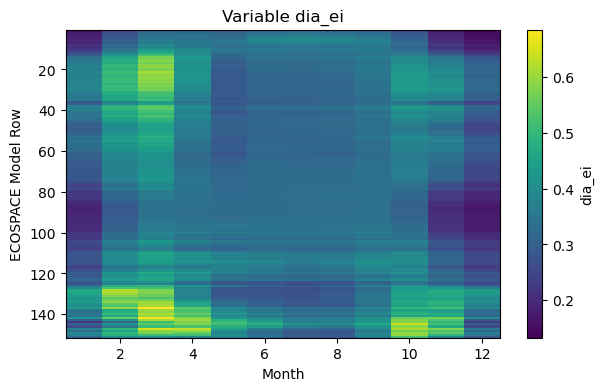

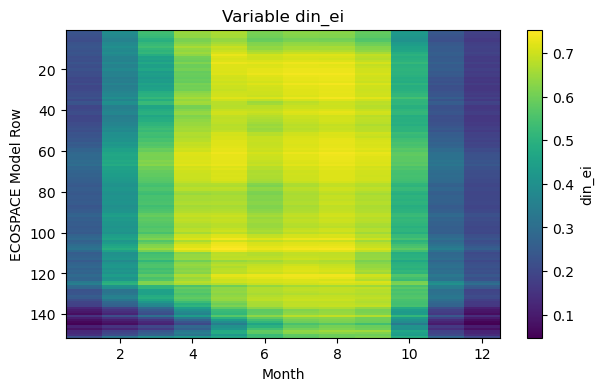

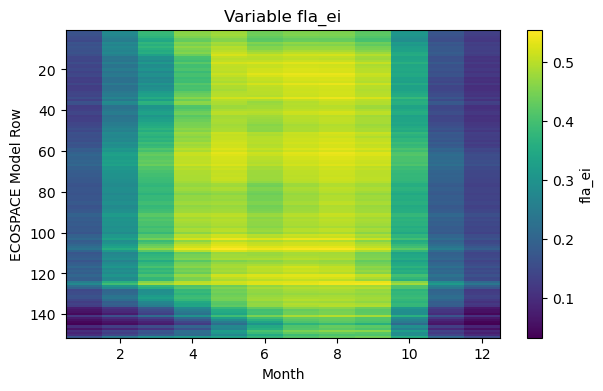

In [18]:
# climatologies
for v in v_ei:
    v1 = ds_NS[v]
    q = v1.groupby('time.month').mean(dim='time').T

    fig, axs = plt.subplots(figsize = (7,4))
    xr.plot.pcolormesh(q, ax = axs)
    axs.set_title('Variable {v}'.format(v=v))
    #plt.colorbar(w, ax = axs)

    axs.invert_yaxis()
    axs.set_xlabel('Month')
    axs.set_ylabel('ECOSPACE Model Row')

### Deviations from the clim along N-S

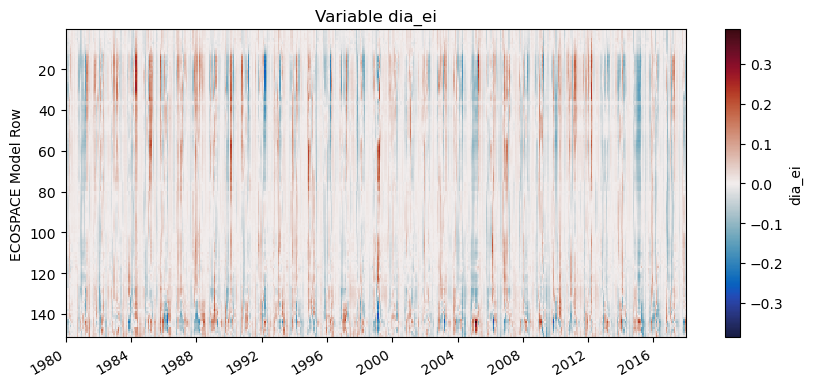

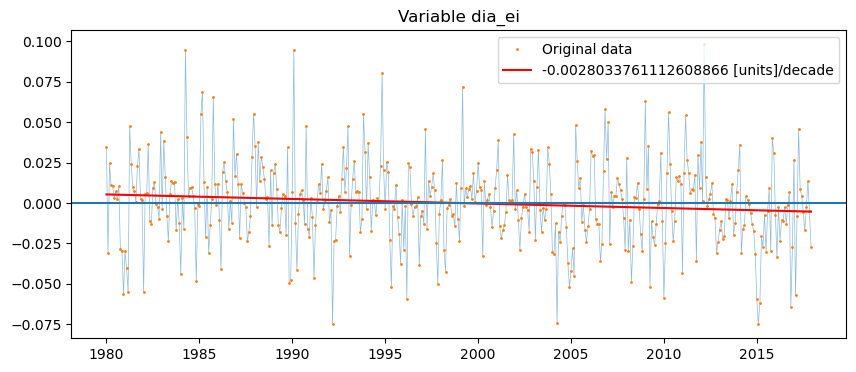

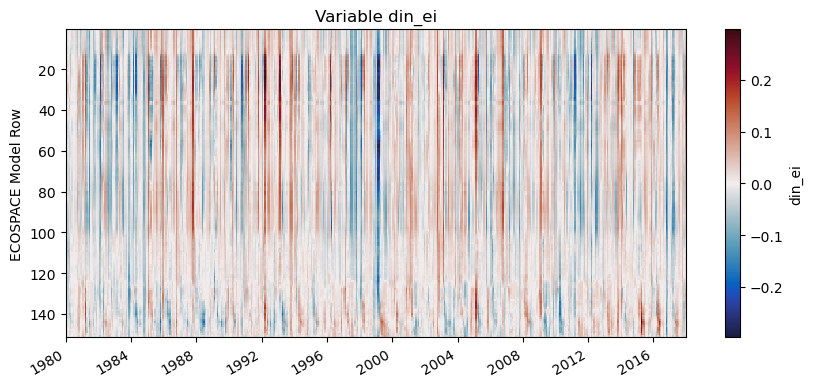

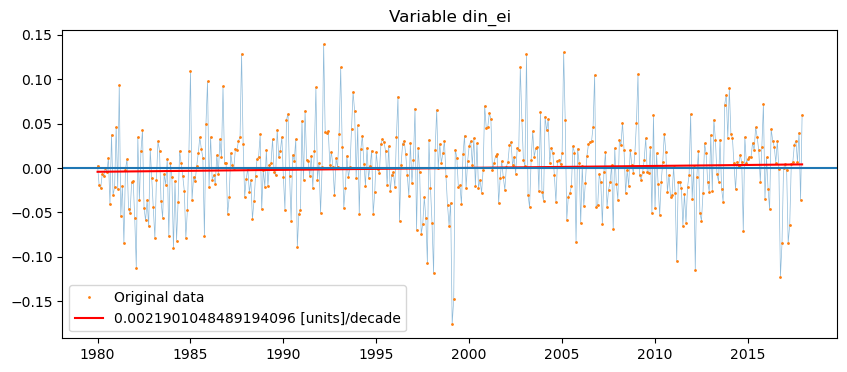

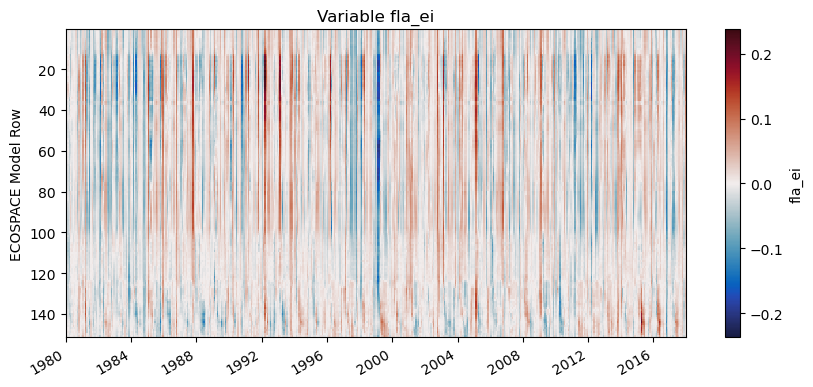

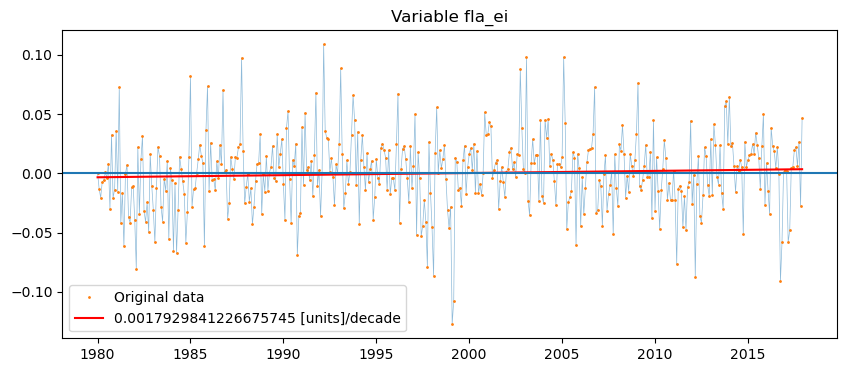

In [19]:
#var_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

for v in v_ei:
    v1 = ds_NS[v]
    
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    #anom =  anom.isel(row = (anom.row > 0) & (anom.row < 30)) # change rows, explore n-s trends
    
    fig, axs = plt.subplots(figsize = (10,4))
    xr.plot.pcolormesh(anom, ax = axs,cmap = cm.cm.balance)
    axs.set_title('Variable {v}'.format(v=v))
    #plt.colorbar(w, ax = axs)
    
    axs.invert_yaxis()
    axs.set_xlabel('')
    axs.set_ylabel('ECOSPACE Model Row')
    
    # lin regress trend
    tyr = np.arange(yr_strt,yr_end+1,1/12)
    fig, axs = plt.subplots(figsize = (10,4))
    
    mean_anom =  anom.isel(row = (anom.row > 0) & (anom.row < 151)).mean(dim = 'row') # change rows, explore n-s trends
    axs.plot(tyr, mean_anom.values,linewidth = 0.5, alpha = 0.5)
    
    x = tyr[~np.isnan(mean_anom.values)]
    y = mean_anom.values[~np.isnan(mean_anom.values)]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    axs.plot(x, y, '.', label='Original data', markersize=2)
    axs.plot(x, m*x + c, 'r', label=f'{m*10} [units]/decade')
    axs.legend(loc = 'best')
    axs.axhline(y=0)
    axs.set_title('Variable {v}'.format(v=v))

### N-S Analysis again but seasonal this time

In [20]:
seasons = ["winter", "spring", "summer", "fall"]

# empty ds for all 
ds_season = xr.Dataset(
    coords={
        'time': time,
        'season':seasons,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'dataset of N-S Seasonal analysis',
    }
)

# empty variable with correct shape for ds2
for v in v_ei:
    ds_season[v] = xr.DataArray(
        np.nan*np.zeros((len(time), len(seasons), rows, cols)),
        dims=('time','season','row', 'col'),
        attrs={'description': f'{v}'}
    )

print("populating enviro indices with season tag")    

# Calculates row-wise averages for each attribute and each month
for v in v_ei:
    m1=12; m2=1; m3=2 # start w/ winter
    for season in seasons:
        for y in range(yr_strt, yr_end+1):   
            for m in sorted(months_d.keys()):
                if((int(m)==m1)|(int(m)==m2)|(int(m)==m3)):
                    # Select the data for this attribute and month

                    if (v == "dia_ei"):
                        data = dia_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
                    elif (v == "din_ei"):
                        data = din_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
                    elif (v == "fla_ei"):
                        data = fla_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
                    else:
                        print("error")
                        break


                    ds_season[v].loc[{'time':f'{y}-{m}-15'.format(year=y,month=m),'season':season}] = xr.DataArray(
                            data.values[0,...],
                            dims=('row','col'),
                            attrs={'description': f'{v} EI index for {y} month {m} season {seasons}'.format(var=v,year=y,month=m, season=season)}
                        )
        m1+=3; m2+=3; m3+=3
print('---------------------------------------')
print(ds_season)
print('---------------------------------------')
print("averaging row-wise and averaging by year grouped by season")    
#time_season = time[(time.month == m1)|(time.month == m2)|(time.month == m3)]

# second dataset to store the row-wise averages 
ds_seas_NS = xr.Dataset(
    coords={
        'time': time,
        'season':seasons,
        'row': range(1, rows+1), 
    },
    attrs={
        'description': 'dataset for N-S seasonal analysis row-wise',
    }
)

# empty variable with correct shape for ds2
for v in v_ei:
    ds_seas_NS[v] = xr.DataArray(
        np.nan*np.zeros((len(time), len(seasons), rows)),
        dims=('time','season','row'),
        attrs={'description': f'{v} avg seasonal along N-S axis (row-wise)'}
    )

# Calculates row-wise averages for each attribute and each season
for v in v_ei:
    m1=12; m2=1; m3=2 # start w/ winter
    for season in seasons:
        for y in range(yr_strt, yr_end+1):

                for m in sorted(months_d.keys()):
                    if((int(m)==m1)|(int(m)==m2)|(int(m)==m3)):
                        data = ds_season[v].sel(time=f'{y}-{m}'.format(y=y,m=m),season=season)

                        # Calculate the row-wise average and print it
                        row_avg = data.mean(dim='col')

                        ds_seas_NS[v].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m),'season':season}] = xr.DataArray(
                                row_avg[0],
                                dims=('row'),
                                attrs={'description': f'{v} avg row-wise data for year {y} month {m}'.format(var=v,year=y,month=m)}
                            )
        m1+=3; m2+=3; m3+=3

print('---------------------------------------')
print(ds_NS_seas_rw)
print("completed")

populating enviro indices with season tag
---------------------------------------
<xarray.Dataset>
Dimensions:  (time: 456, season: 4, row: 151, col: 93)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-15 1980-02-15 ... 2017-12-15
  * season   (season) <U6 'winter' 'spring' 'summer' 'fall'
  * row      (row) int32 1 2 3 4 5 6 7 8 9 ... 144 145 146 147 148 149 150 151
  * col      (col) int32 1 2 3 4 5 6 7 8 9 10 ... 84 85 86 87 88 89 90 91 92 93
Data variables:
    dia_ei   (time, season, row, col) float64 nan nan 0.002847 ... nan nan nan
    din_ei   (time, season, row, col) float64 nan nan 1.702e-07 ... nan nan nan
    fla_ei   (time, season, row, col) float64 nan nan 2.288e-08 ... nan nan nan
Attributes:
    description:  dataset of N-S Seasonal analysis
---------------------------------------
averaging row-wise and averaging by year grouped by season
---------------------------------------


NameError: name 'ds_NS_seas_rw' is not defined

C:\Users\Greig\AppData\Local\Temp\ipykernel_8468\2723428215.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (8,5))


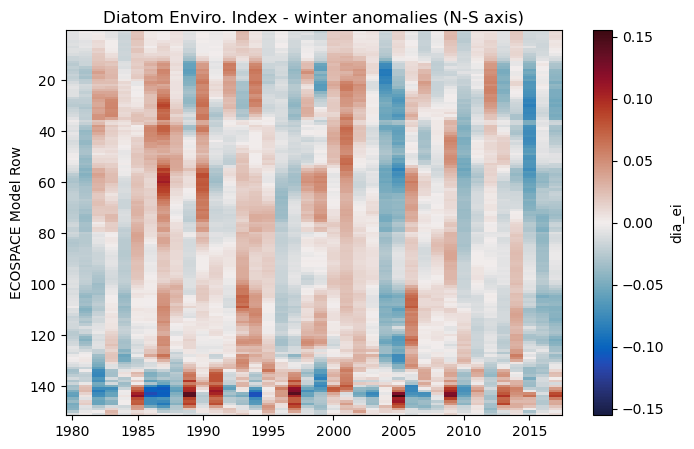

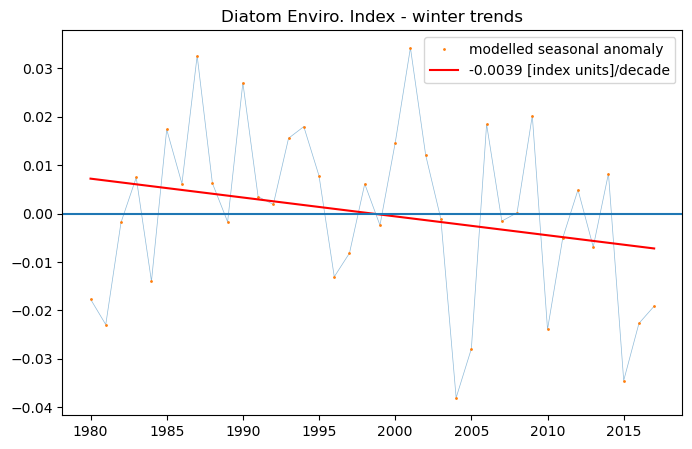

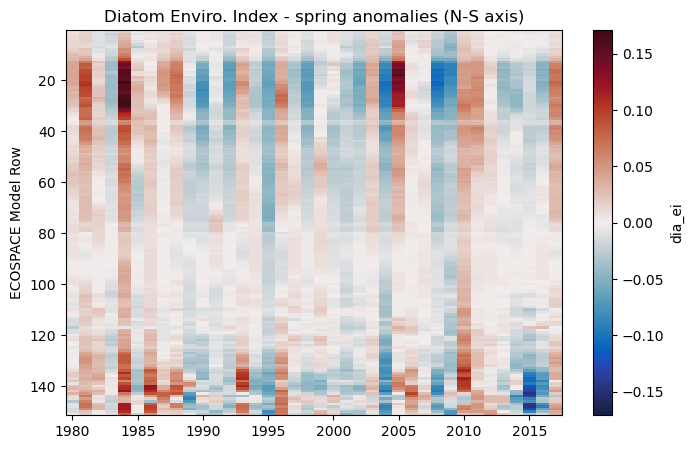

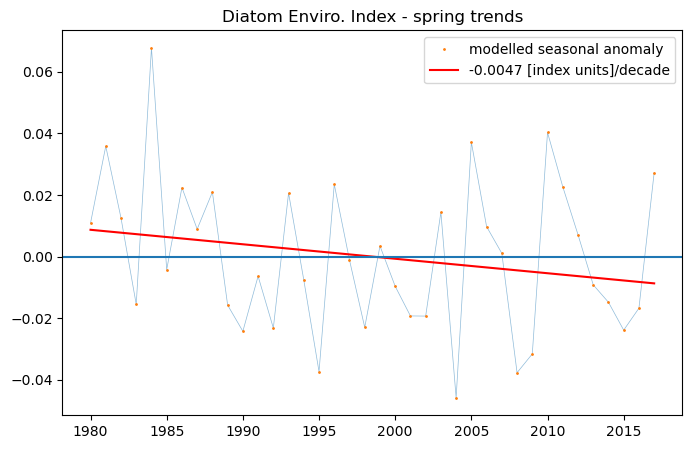

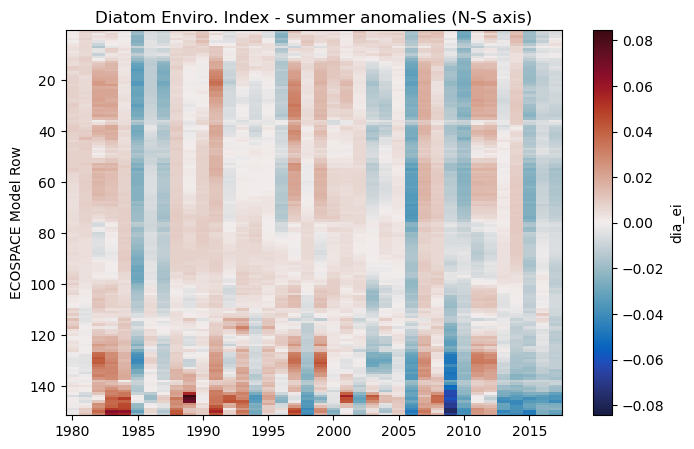

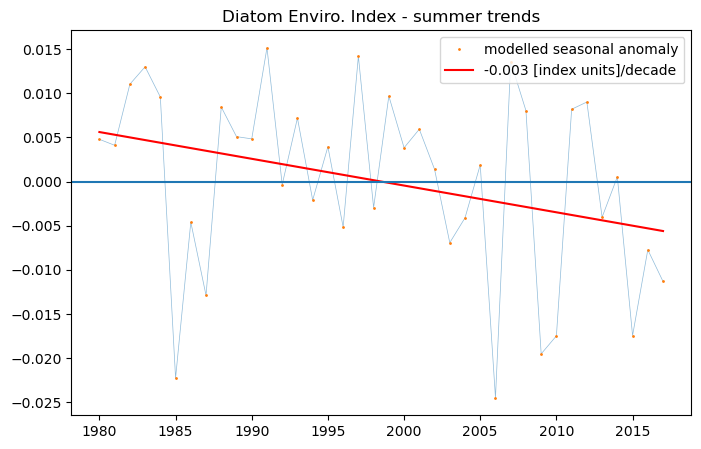

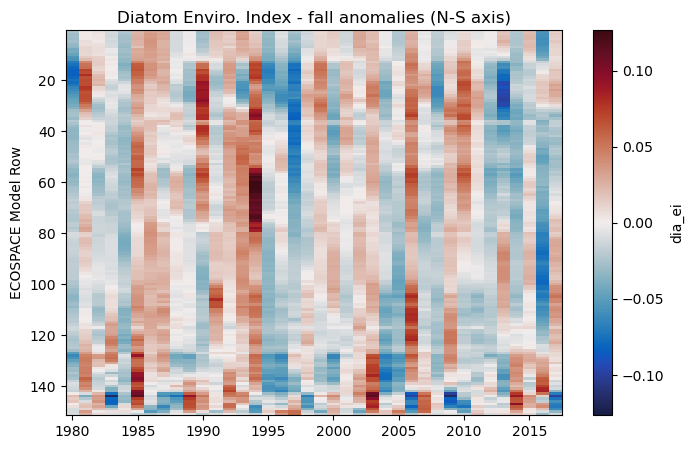

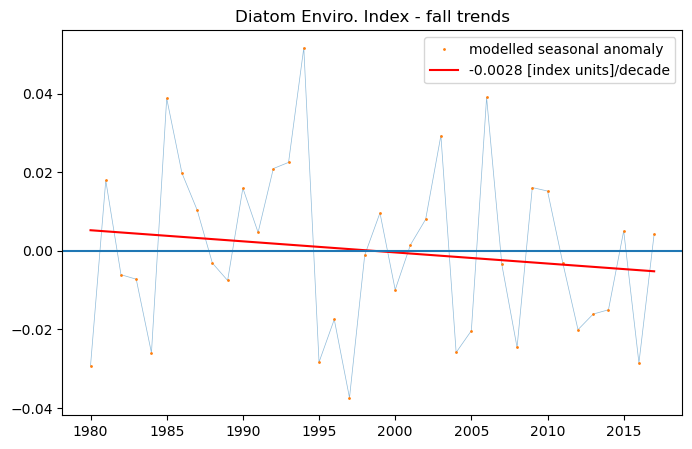

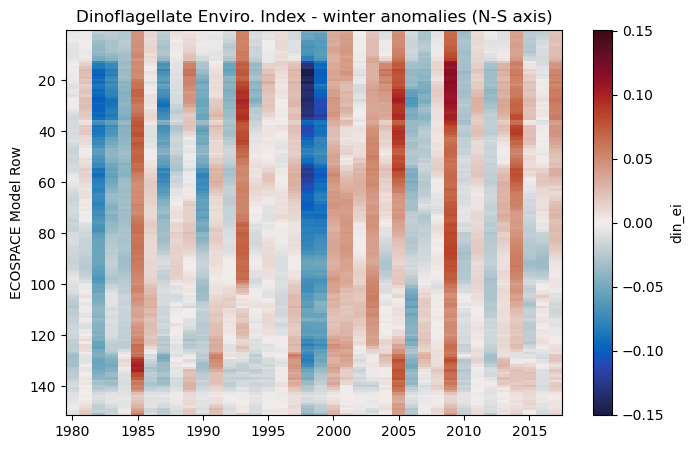

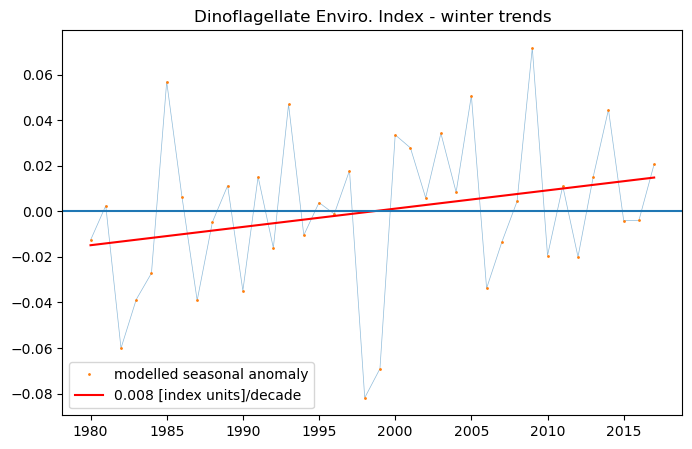

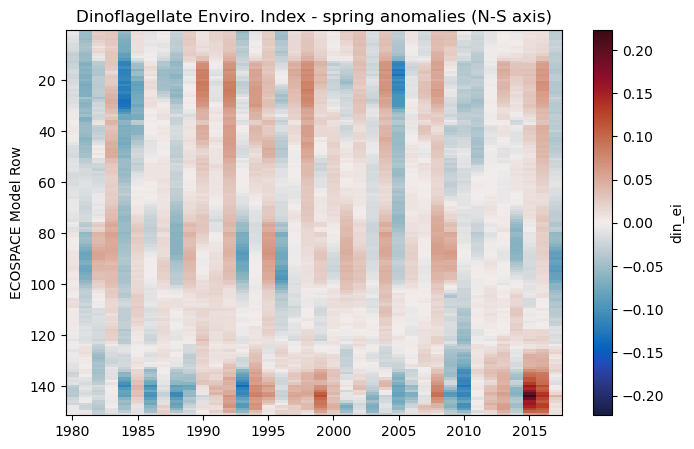

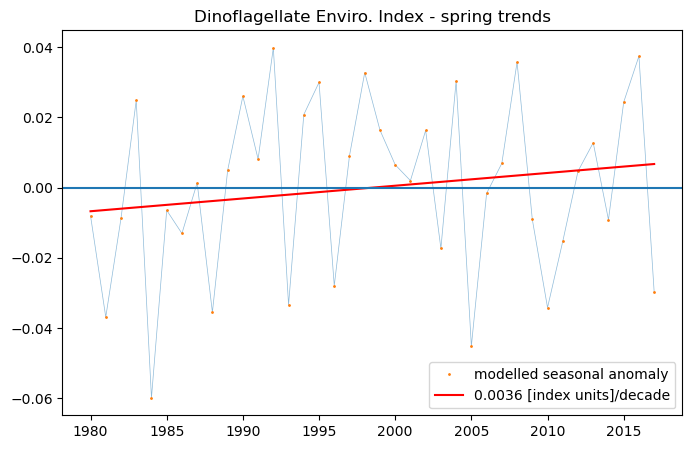

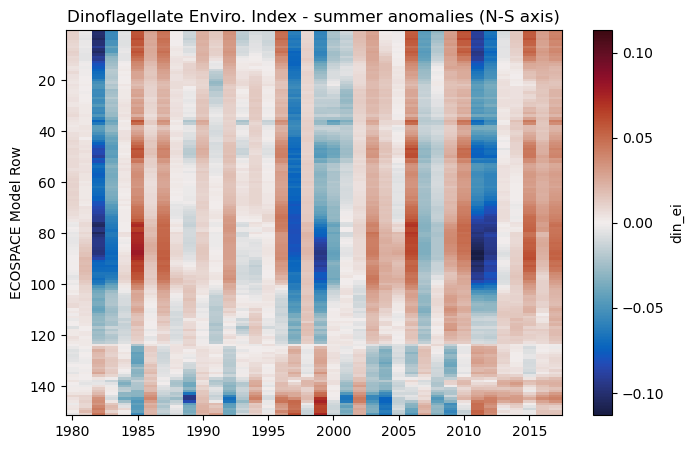

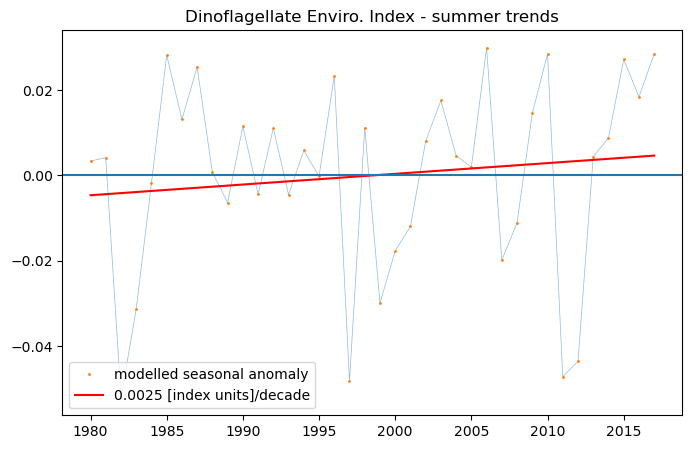

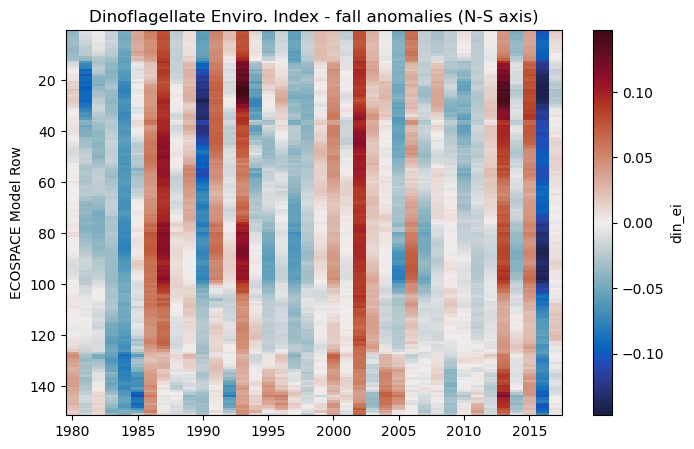

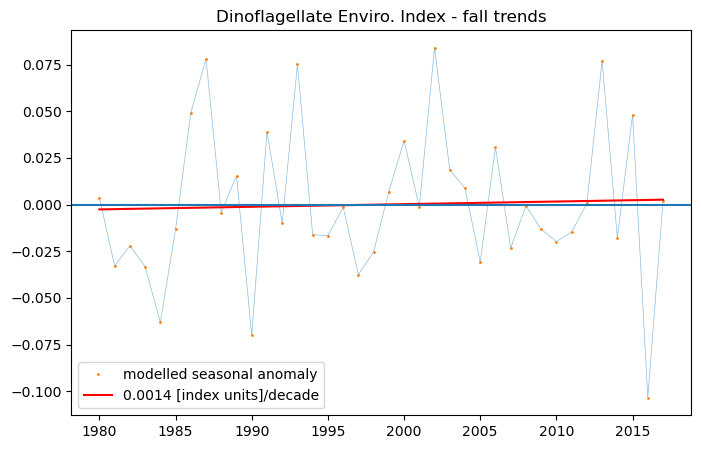

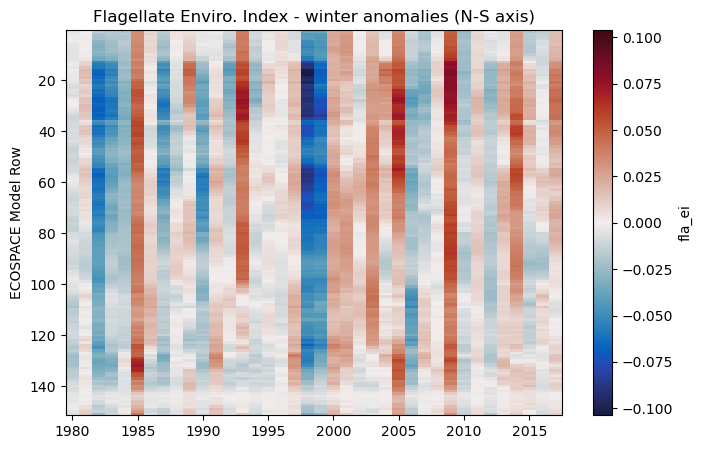

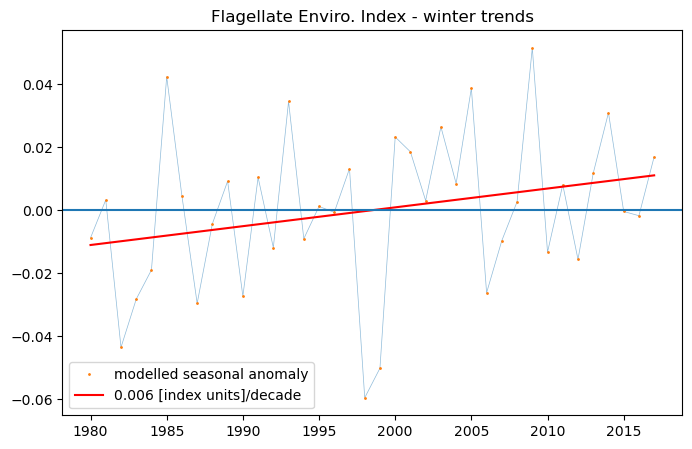

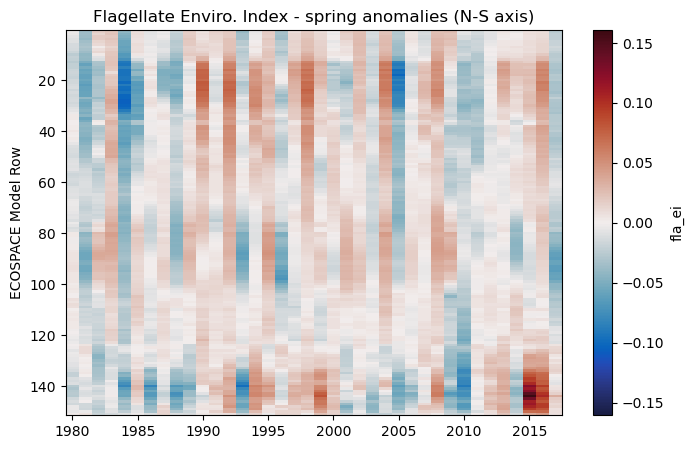

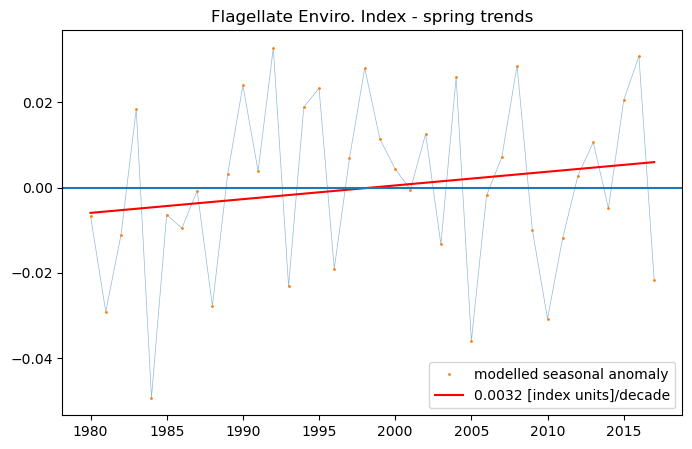

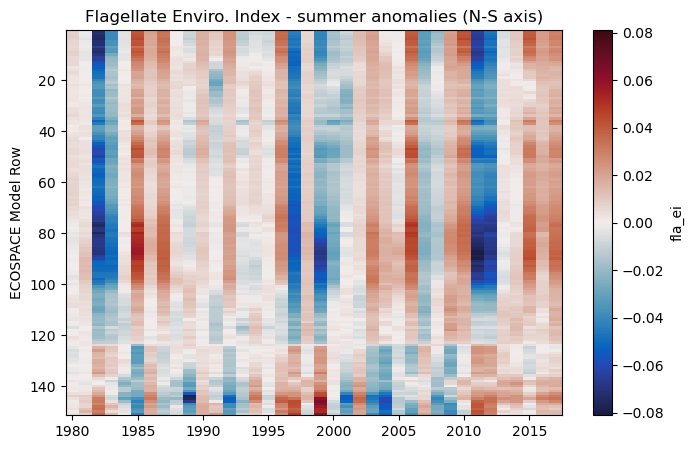

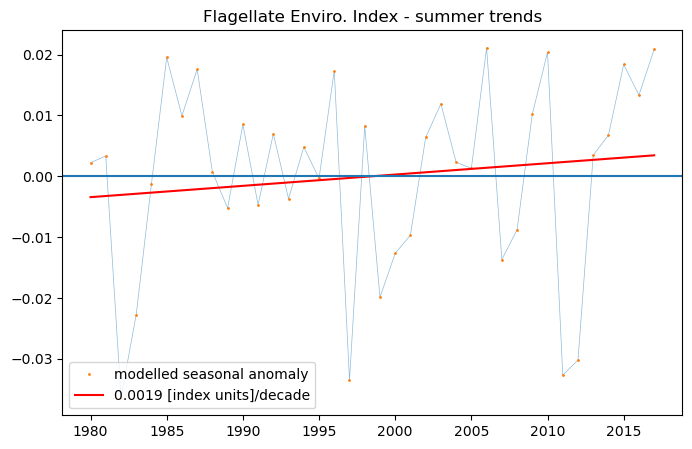

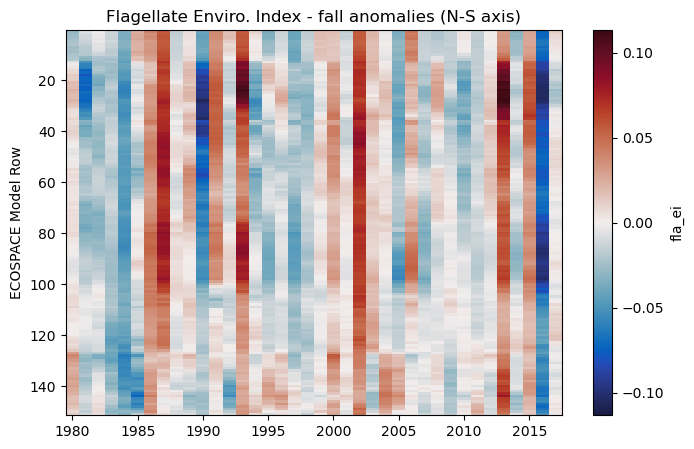

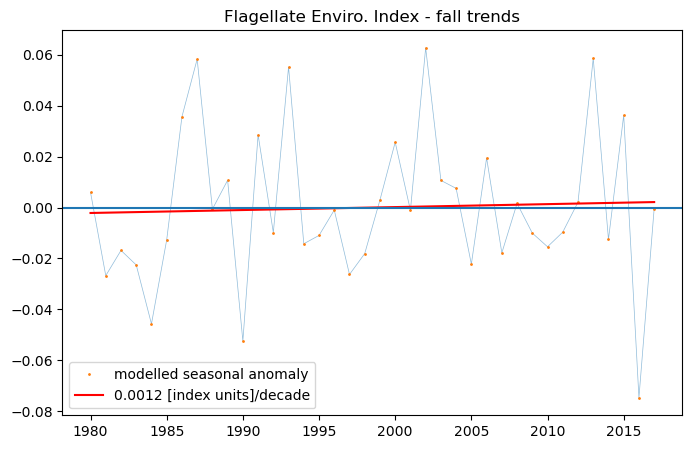

In [21]:
#var_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

for v in v_ei:
    
    
    allseasons_clima = ds_seas_NS[v].groupby('season').mean(dim='time')
    allseasons_data = ds_seas_NS[v].groupby('time.year').mean(dim='time')
    
    if (v == "dia_ei"):
        label = "Diatom Enviro. Index"
    elif (v == "din_ei"):
        label = "Dinoflagellate Enviro. Index"
    elif (v == "fla_ei"):
        label = "Flagellate Enviro. Index"
    else:
        print("error")
    
    
    for season in seasons:
        
        clim = allseasons_clima.sel(season=season)
        anom = (allseasons_data.sel(season=season) - clim).T
        
        #anom =  anom.isel(row = (anom.row > 0) & (anom.row < 30)) # change rows, explore n-s trends

        fig, axs = plt.subplots(figsize = (8,5))
        xr.plot.pcolormesh(anom, ax = axs,cmap = cm.cm.balance)
        axs.set_title('{label} - {season} anomalies (N-S axis)'.format(label=label,season=season))
        #plt.colorbar(w, ax = axs)

        axs.invert_yaxis()
        axs.set_xlabel('')
        axs.set_ylabel('ECOSPACE Model Row')

        # lin regress trend
        tyr = np.arange(yr_strt,yr_end+1,1)
        fig, axs = plt.subplots(figsize = (8,5))

        mean_anom =  anom.isel(row = (anom.row > 0) & (anom.row < 151)).mean(dim = 'row') # change rows, explore n-s trends
        axs.plot(tyr, mean_anom.values,linewidth = 0.5, alpha = 0.5)

        x = tyr[~np.isnan(mean_anom.values)]
        y = mean_anom.values[~np.isnan(mean_anom.values)]
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        axs.plot(x, y, '.', label='modelled seasonal anomaly', markersize=2)
        axs.plot(x, m*x + c, 'r', label=f'{round(m*10, 4)} [index units]/decade')
        axs.legend(loc = 'best')
        axs.axhline(y=0)
        axs.set_title('{label} - {season} trends'.format(label=label,season=season))

In [431]:
import statsmodels.api as sm

ImportError: cannot import name 'csr_array' from 'scipy.sparse' (C:\Users\Greig\anaconda3\lib\site-packages\scipy\sparse\__init__.py)

In [408]:
allseasons_data

<xarray.DataArray 'fla_ei' (year: 38, season: 4, row: 151)>
array([[[0.61787402, 0.62021971, 0.6057065 , ..., 0.29174833,
         0.30837939, 0.42649698],
        [0.68670532, 0.67132307, 0.67452254, ..., 0.2111466 ,
         0.19227566, 0.20016405],
        [0.72457237, 0.71711557, 0.71641971, ..., 0.28332728,
         0.25852789, 0.22168685],
        [0.64058009, 0.64637543, 0.6371714 , ..., 0.47885575,
         0.46651758, 0.49902262]],

       [[0.6360744 , 0.63586294, 0.62019157, ..., 0.32331003,
         0.34947703, 0.45582678],
        [0.76882669, 0.7535343 , 0.75255883, ..., 0.25747919,
         0.23586233, 0.24214596],
        [0.75010004, 0.7449104 , 0.74695602, ..., 0.32159266,
         0.301483  , 0.25442051],
        [0.70718179, 0.70809473, 0.69230008, ..., 0.45345406,
         0.4460992 , 0.49825285]],

       [[0.61200298, 0.6034609 , 0.5828932 , ..., 0.27679584,
         0.30291765, 0.41287198],
...
        [0.7683731 , 0.7735193 , 0.75964453, ..., 0.52576697,
         0.51178059, 0.54330636]],

       [[0.60970351, 0.612349  , 0.59837364, ..., 0.28194617,
         0.30050147, 0.42516367],
        [0.62125544, 0.60915511, 0.6135418 , ..., 0.29225953,
         0.26014286, 0.23047198],
        [0.66979691, 0.65800192, 0.65653123, ..., 0.26779354,
         0.24566197, 0.20895353],
        [0.56419335, 0.57277719, 0.55899303, ..., 0.39176886,
         0.39057691, 0.48342726]],

       [[0.67012064, 0.67189773, 0.65641791, ..., 0.3186834 ,
         0.34031553, 0.45433375],
        [0.73974787, 0.72324628, 0.72203268, ..., 0.29042691,
         0.26740934, 0.26664169],
        [0.65440842, 0.6470423 , 0.64549558, ..., 0.26552593,
         0.24310683, 0.21225858],
        [0.7135201 , 0.70824202, 0.69438816, ..., 0.46230924,
         0.45752648, 0.49599086]]])
Coordinates:
  * season   (season) <U6 'winter' 'spring' 'summer' 'fall'
  * row      (row) int32 1 2 3 4 5 6 7 8 9 ... 144 145 146 147 148 149 150 151
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2013 2014 2015 2016 2017

In [428]:
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.tsa.seasonal as seasonal

# Generate a synthetic time series
np.random.seed(0)
n = 100
x = np.arange(n)
y = 2 * x + 5 + np.random.randn(n)

# Perform trend analysis with breakpoints
breakpoints = [50]  # Insert breakpoints at index 50
exog = sm.add_constant(x)  # Add constant term for the regression
endog = y.copy()

# Fit segmented regression model
seg_model = seasonal.UnobservedComponents(endog, exog=exog, trend=True, freq_seasonal=None)
seg_results = seg_model.fit(start_params=[0] * (len(breakpoints) + 2))

# Predict the segmented regression
pred = seg_results.predict(start=0, end=n-1, exog=exog)

# Print the breakpoints and estimated coefficients
print("Breakpoints:", breakpoints)
print("Coefficients:", seg_results.params)

# Plot the original and predicted time series
import matplotlib.pyplot as plt

plt.plot(x, y, label='Original')
plt.plot(x, pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


ImportError: cannot import name 'csr_array' from 'scipy.sparse' (C:\Users\Greig\anaconda3\lib\site-packages\scipy\sparse\__init__.py)

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [430]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} scipy

Solving environment: ...working... done

# All requested packages already installed.

